In [1]:
import argparse
import sys, os
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/stylegan2'))
sys.path.append(os.path.join(sys.path[0], '/home/ibespalov/unsupervised_pattern_segmentation/gans_pytorch/gan/'))
from gan.gan_model import cont_style_munit_enc
from models.munit.enc_dec import MunitEncoder
from parameters.dataset import DatasetParameters
from parameters.deformation import DeformationParameters
from parameters.gan import GanParameters, MunitParameters

import albumentations
import torch
from albumentations.pytorch.transforms import ToTensor as AlbToTensor
from dataset.cardio_dataset import ImageMeasureDataset
from torch.utils import data
from transforms_utils.transforms import MaskToMeasure
from dataset.d300w import ThreeHundredW
from dataset.probmeasure import ProbabilityMeasureFabric, ProbabilityMeasure
import numpy as np

In [2]:
import matplotlib.pyplot as plt

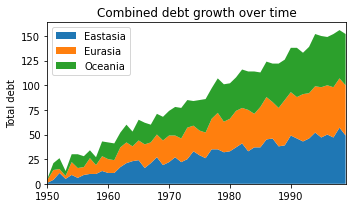

In [3]:
import numpy as np
import matplotlib.pyplot as plt
 
rng = np.arange(50)
rnd = np.random.randint(0, 10, size=(3, rng.size))
yrs = 1950 + rng
 
fig, ax = plt.subplots(figsize=(5, 3))
ax.stackplot(yrs, rng + rnd, labels=['Eastasia', 'Eurasia', 'Oceania'])
ax.set_title('Combined debt growth over time')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()
 
plt.show()

In [4]:
from transforms_utils.transforms import MaskToMeasure, MeasureToKeyPoints, MeasureToMask, KeyPointsToMeasure, ToNumpy
from albumentations import BasicTransform, DualTransform

In [5]:
device = torch.device("cpu")#"cuda:2" if torch.cuda.is_available() else "cpu")
print(device)
#torch.cuda.set_device(device)

dataset = ThreeHundredW("/raid/data/300w", train=True, imwidth=500, crop=15)

loader = data.DataLoader(
        dataset,
        batch_size=8,
        drop_last=True,
    )

test_dataset = ThreeHundredW("/raid/data/300w", train=False, imwidth=500, crop=15)

test_loader = data.DataLoader(
        test_dataset,
        batch_size=8,
        drop_last=True,
    )
batch = next(iter(loader))

cpu


In [6]:
image, landmarks = batch['data'], batch['meta']['keypts_normalized']

In [7]:
landmarks_prob = ProbabilityMeasureFabric(256).from_coord_tensor(landmarks)

In [43]:
class MeasureToKeyPoints1(BasicTransform):
    def __init__(self):
        super(MeasureToKeyPoints1, self).__init__(1)
        
    def __call__(self, force_apply=False, **kwargs):
        img = kwargs['image']
        mes = kwargs['measure']
        prob = mes.probability
        print("mes.coord shape", mes.coord.shape)
        print("mes.coord[:, 1]", mes.coord[:, 1])
        print("mes.coord[:, 0]", mes.coord[:, 0])
        return {'keypoints': [[mes.coord[:,:, 1], mes.coord[:,:, 0], 0, 1]], 'image': img, 'prob': prob}

In [46]:
class KeyPointsToMeasure2(BasicTransform):
    def __init__(self):
        super(KeyPointsToMeasure2, self).__init__(1)
        
    def __call__(self, force_apply=False, **kwargs):
        img = kwargs['image']
        keypoints = kwargs['keypoints']
        x, y, _, _ = keypoints[0]
        x = torch.tensor(x)
        y = torch.tensor(y)
        prob = kwargs['prob']
        return {'img': img, 'measure': ProbabilityMeasure(prob, torch.cat([y[..., None], x[..., None]], dim=-1))}

In [47]:
class ToNumpy1(DualTransform):
    def __init__(self):
        super(ToNumpy1, self).__init__(1)

    def apply(self, img: torch.Tensor, **params):
        return np.transpose(img.detach().cpu().numpy(), [0, 2, 3, 1])

    def apply_to_mask(self, mask: torch.Tensor, **params):
        return np.transpose(mask.detach().cpu().numpy(), [0, 2, 3, 1])

    def apply_to_keypoint(self, keypoint, **params):
        x, y, a, s = keypoint
        return x.detach().cpu().numpy(), y.detach().cpu().numpy(), a, s

In [52]:
from joblib import Parallel, delayed
class NumpyBatch(BasicTransform):

    def __init__(self, transform: BasicTransform):
        super(NumpyBatch, self).__init__(1)
        self.transform = transform

    def __call__(self, force_apply=False, **kwargs):
        img = kwargs["image"]
        prob = kwargs["prob"]
        x, y, a, s = kwargs["keypoints"][0]
        
        batch_img = []
        batch_x = []
        batch_y = []

        
        def compute(transform, img_i, x_i, y_i):
            data_i = transform(image=img_i, keypoints=[[x_i, y_i, a, s]])
            return data_i
        
        processed_list = [compute(self.transform, img[i], x[i], y[i]) for i in range(img.shape[0])]
        #processed_list = Parallel(n_jobs=16)(delayed(compute)(self.transform, img[i], x[i], y[i]) for i in range(img.shape[0]))

        # print(time.time() - t1)

        for data in processed_list:
            batch_img.append(data["image"][np.newaxis, ...])
            x, y, _, _ = data["keypoints"][0]
            batch_x.append(x[np.newaxis, ...])
            batch_y.append(y[np.newaxis, ...])
            print("X max", np.max(x))
            print("Y max", np.max(y))
        return {
            "image": np.concatenate(batch_img, axis=0),
            "keypoints": [[np.concatenate(batch_x, axis=0), np.concatenate(batch_y, axis=0), a, s]],
            "prob": prob
                }


In [53]:
g_transforms: albumentations.DualTransform = albumentations.Compose([
        MeasureToKeyPoints1(),
        ToNumpy1(),
        NumpyBatch(albumentations.ShiftScaleRotate()),
        KeyPointsToMeasure2()
    ])

In [54]:
res_dict = g_transforms(image=image, measure=landmarks_prob)

mes.coord shape torch.Size([8, 68, 2])
mes.coord[:, 1] tensor([[0.2387, 0.4802],
        [0.2248, 0.4749],
        [0.2392, 0.4189],
        [0.2710, 0.5138],
        [0.1848, 0.4791],
        [0.2365, 0.4219],
        [0.2521, 0.4998],
        [0.2568, 0.5104]])
mes.coord[:, 0] tensor([[0.2355, 0.3990],
        [0.2344, 0.3950],
        [0.2548, 0.3343],
        [0.2797, 0.4461],
        [0.1844, 0.3935],
        [0.2446, 0.3429],
        [0.2652, 0.4246],
        [0.2502, 0.4342]])
X max 0.87722427
Y max 0.7584779
X max 41.321182
Y max -57.077225
X max -17.088326
Y max 28.912931
X max 65.274956
Y max -66.991646
X max 0.88940716
Y max 0.73741716
X max 0.9068
Y max 0.7545228
X max -63.908207
Y max 27.85868
X max 0.820137
Y max 0.79633373


AssertionError: 

In [12]:
matrix = cv2.getRotationMatrix2D((0,0), 0, 0)

NameError: name 'cv2' is not defined

In [12]:
import cv2 
x, y = np.ones(68), np.ones(68)
sqr = np.ones((8,1,2))
# polygon = np.array([(0,0),(100,10),(100,-10)],np.int32)
x = cv2.transform(sqr, matrix).squeeze()

NameError: name 'matrix' is not defined

In [13]:
np.array([[x], [y]]).shape

(2, 1, 68)

In [24]:
res = np.transpose(np.array([[x], [y]]),(1,2,0))
print(res.shape)
print(res[0,:,0].squeeze().shape)
print(res[0,:,1].shape)

(1, 68, 2)
(68,)
(68,)


In [14]:
import numpy as np  
import cv2

dx,dy = 400,400
centre = dx//2,dy//2
img = np.zeros((dy,dx),np.uint8)

# construct a long thin triangle with the apex at the centre of the image
polygon = np.array([(0,0),(100,10),(100,-10)],np.int32)
polygon += np.int32(centre)

# draw the filled-in polygon and then rotate the image
cv2.fillConvexPoly(img,polygon,(255))
M = cv2.getRotationMatrix2D(centre,20,1) # M.shape =  (2, 3)
rotatedimage = cv2.warpAffine(img,M,img.shape)

# as an alternative, rotate the polygon first and then draw it

# these are alternative ways of coding the working example
# polygon.shape is 3,2

# magic that makes sense if one understands numpy arrays
poly1 = np.reshape(polygon,(3,1,2))
# slightly more accurate code that doesn't assumy the polygon is a triangle
poly2 = np.reshape(polygon,(polygon.shape[0],1,2))
# turn each point into an array of points
poly3 = np.array([[p] for p in polygon])
# use an array of array of points 
poly4 = np.array([polygon])
# more magic 
poly5 = np.reshape(polygon,(1,3,2))

for poly in (poly1,poly2,poly3,poly4,poly5):
    newimg = np.zeros((dy,dx),np.uint8)
    print("POLY PUBLICATION", poly.shape)
    print("MAMA", M.shape)
    rotatedpolygon = cv2.transform(poly,M)
    print("RESULTAT IGORYA IVANOVICHA", rotatedpolygon.shape)
    cv2.fillConvexPoly(newimg,rotatedpolygon,(127))

POLY PUBLICATION (3, 1, 2)
MAMA (2, 3)
RESULTAT IGORYA IVANOVICHA (3, 1, 2)
POLY PUBLICATION (3, 1, 2)
MAMA (2, 3)
RESULTAT IGORYA IVANOVICHA (3, 1, 2)
POLY PUBLICATION (3, 1, 2)
MAMA (2, 3)
RESULTAT IGORYA IVANOVICHA (3, 1, 2)
POLY PUBLICATION (1, 3, 2)
MAMA (2, 3)
RESULTAT IGORYA IVANOVICHA (1, 3, 2)
POLY PUBLICATION (1, 3, 2)
MAMA (2, 3)
RESULTAT IGORYA IVANOVICHA (1, 3, 2)


In [14]:
albumentations.ShiftScaleRotate().apply_to_keypoints([[np.ones(68), np.ones(68), 0, 1]])

[(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  0.0,
  0)]

In [15]:
res_dict = g_transforms(image=image, measure=landmarks_prob)

mes.coord shape torch.Size([8, 68, 2])
mes.coord[:, 1] tensor([[0.2387, 0.4802],
        [0.2248, 0.4749],
        [0.2392, 0.4189],
        [0.2710, 0.5138],
        [0.1848, 0.4791],
        [0.2365, 0.4219],
        [0.2521, 0.4998],
        [0.2568, 0.5104]])
mes.coord[:, 0] tensor([[0.2355, 0.3990],
        [0.2344, 0.3950],
        [0.2548, 0.3343],
        [0.2797, 0.4461],
        [0.1844, 0.3935],
        [0.2446, 0.3429],
        [0.2652, 0.4246],
        [0.2502, 0.4342]])
QWE
x (8, 68)
y (8, 68)
a 0
s 1
8
x_i [0.39895797 0.4802117  0.5639863  0.64243245 0.7169807  0.77584916
 0.82787734 0.8642541  0.87722427 0.868471   0.83012396 0.77721584
 0.71407807 0.6432999  0.5708035  0.5000795  0.42467007 0.3526258
 0.31993288 0.30987948 0.31715697 0.33494258 0.3353681  0.31951484
 0.31174868 0.3211044  0.3525876  0.40283754 0.45245522 0.5011172
 0.5509748  0.5832496  0.5874009  0.59867054 0.58929795 0.5824404
 0.412537   0.3894847  0.38956514 0.4254041  0.42462924 0.42360654
 0.4301

ValueError: not enough values to unpack (expected 4, got 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


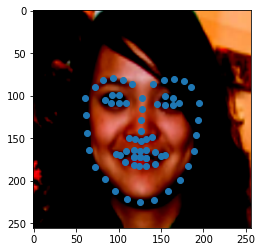

In [24]:
plt.imshow(np.transpose(image.numpy()[0], (1,2,0)))#, (1,2,0)))
# res_dict['keypoint'].coord[:,0]# .toImage(256)
plt.scatter(res_dict['keypoint'].coord[0,:,0].numpy()*256, res_dict['keypoint'].coord[0,:,1].numpy()*256)
plt.show()


In [23]:
def center_by_face(image: torch.Tensor, landmarks: torch.Tensor):
    y_center = int(landmarks[36][0] + landmarks[45][0]) // 2
    x_center = int(landmarks[:,1].mean().item())
    keypoints_landmarks = [landmarks[:,0].numpy(), landmarks[:,1].numpy(), 0, 1]
    C, H, W = image.shape
    W_max = min(x_center, W - x_center)
    H_max = min(y_center, H - y_center)
    radius = min(W_max, H_max)
    y_max, y_min = y_center + radius, y_center - radius
    x_max, x_min = x_center + radius, x_center - radius
    transforms = albumentations.Compose([
        albumentations.Crop(x_min=y_min, y_min=x_min, x_max=y_max, y_max=x_max),
#         albumentations.Resize(256, 256)
    ])
    data_dict = transforms(image=np.transpose(image.numpy(), (1,2,0)), keypoints=[keypoints_landmarks])
    image_new = torch.tensor(np.transpose(data_dict['image'], (2,0,1)))
    kp_x, kp_y = data_dict['keypoints'][0][1], data_dict['keypoints'][0][0]
    keypoints_new = torch.cat([torch.tensor(kp_y)[..., None], torch.tensor(kp_x)[..., None]], dim=1)
    return image_new, keypoints_new

In [92]:
def center_by_face(image: torch.Tensor, landmarks: torch.Tensor):
    image, landmarks = np.transpose(image.numpy(), (1,2,0)), landmarks.numpy()
    y_center = int(landmarks[36][0] + landmarks[45][0]) // 2
    x_center = int(landmarks[:,1].mean().item())
    y, x = landmarks[:,0], landmarks[:,1]
    keypoints_landmarks = [x, y, 0, 1]
    H, W, C = image.shape
    W_max = min(x_center, W - x_center)
    H_max = min(y_center, H - y_center)
    radius = min(W_max, H_max)
    y_max, y_min = min(H, y_center + H//2), max(0, y_center - H//2)
    x_max, x_min = min(W,x_center + W//2), max(0, x_center - W//2)
    transforms = albumentations.Compose([
        albumentations.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max),
        albumentations.Resize(256, 256)
    ])
    data_dict = transforms(image=image, keypoints=[keypoints_landmarks])
    image_new = torch.tensor(np.transpose(data_dict['image'], (2,0,1)))
    kp_x, kp_y = data_dict['keypoints'][0][0], data_dict['keypoints'][0][1]
    keypoints_new = torch.cat([torch.tensor(kp_x)[..., None], torch.tensor(kp_y)[..., None]], dim=1)
    return image_new, keypoints_new

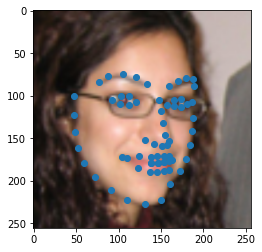

In [93]:
image_init = (dataset[4]['data'] + 1) / 2
keyptssssiki = dataset[4]['meta']['keypts']
image_init, keypoints_new = center_by_face(image_init, keyptssssiki)
# y, x = keyptssssiki[:,0], keyptssssiki[:,1]
# sekretiki = albumentations.Crop(x_min=50, y_min=0, x_max=400, y_max=300)(image=image_init, keypoints=[[x,y,0,1]])
# sekretiki = albumentations.Resize(256,256)(**sekretiki)
# print(keyptssssiki.shape)
plt.imshow(np.transpose(image_init.numpy(), (1,2,0)))#, (1,2,0)))
plt.scatter(keypoints_new.numpy()[:,0], keypoints_new.numpy()[:,1])
plt.show()

(68, 2)


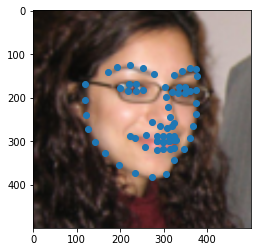

In [90]:
image_init = np.transpose(((dataset[4]['data'] + 1) / 2).numpy(), (1,2,0))
keyptssssiki = dataset[4]['meta']['keypts'].numpy()
y, x = keyptssssiki[:,0], keyptssssiki[:,1]
sekretiki = albumentations.Crop(x_min=50, y_min=0, x_max=400, y_max=300)(image=image_init, keypoints=[[x,y,0,1]])
sekretiki = albumentations.Resize(256,256)(**sekretiki)
print(keyptssssiki.shape)
plt.imshow(image_init)#, (1,2,0)))
plt.scatter(x, y)
plt.show()

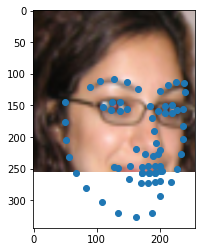

In [91]:
plt.imshow(sekretiki['image'])#, (1,2,0)))
plt.scatter(sekretiki['keypoints'][0][0], sekretiki['keypoints'][0][1])
plt.show()

cpu
QWAQUSHA torch.Size([8, 3, 500, 500])
0.02352941
1.0


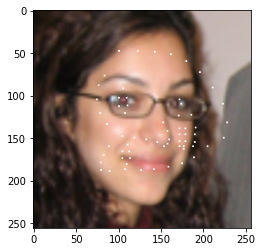

In [87]:
device = torch.device("cpu")#"cuda:2" if torch.cuda.is_available() else "cpu")
print(device)
#torch.cuda.set_device(device)

dataset = ThreeHundredW("/raid/data/300w", train=True, imwidth=500, crop=15)

loader = data.DataLoader(
        dataset,
        batch_size=8,
        drop_last=True,
    )

test_dataset = ThreeHundredW("/raid/data/300w", train=False, imwidth=500, crop=15)

test_loader = data.DataLoader(
        test_dataset,
        batch_size=8,
        drop_last=True,
    )
batch = next(iter(loader))

image, qwa = center_by_face(batch['data'][4], batch['meta']['keypts'][4])
qwa = qwa / max(image.shape)
image = image[None,]
print("QWAQUSHA", batch["data"].shape)


mes = ProbabilityMeasureFabric(256).from_coord_tensor(qwa[None])
mask = mes.toImage(256)
mask = torch.cat([mask, mask, mask], dim=1)
image[mask > 0.00001] = 1
# print(np.transpose(batch['data'].numpy()[0] + 1))
print(((image[0].numpy() + 1) / 2).min())
print(((image[0].numpy() + 1) / 2).max())
plt.imshow(np.transpose((image[0] + 1) / 2, (1,2,0)))
plt.show()

#save_image_with_mask(batch["data"], mes.toImage(256), "test.jpg")


In [27]:
np.sqrt(135519)

368.12905345815886

In [3]:
import argparse
import sys, os
from gan.gan_model import cont_style_munit_enc
from gans_model.models.munit.enc_dec import MunitEncoder

ModuleNotFoundError: No module named 'gans_model'

In [34]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)
    
def sample_data(loader):
    while True:
        for batch in loader:
            yield batch

In [35]:
transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(),
        albumentations.Resize(256, 256),
        albumentations.ElasticTransform(p=0.5, alpha=100, alpha_affine=1, sigma=10),
        albumentations.ShiftScaleRotate(p=0.5, rotate_limit=10),
        albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        AlbToTensor()
    ]
)

In [36]:
dataset = ImageMeasureDataset(
    "/raid/data/celeba",
    "/raid/data/celeba_masks",
    img_transform=transform
)

loader = data.DataLoader(
    dataset,
    batch_size=16,
    sampler=data_sampler(dataset, shuffle=True, distributed=False),
    drop_last=True,
)

In [37]:
loader = sample_data(loader)

In [38]:
test_img, test_mask = next(loader)

ref_measure = MaskToMeasure(size=256, padding=200, clusterize=True)(image=test_img, mask=test_mask)["mask"]




In [41]:
parser = argparse.ArgumentParser(
        parents=[
            DatasetParameters(),
            GanParameters(),
            DeformationParameters(),
            MunitParameters()
        ],
        # formatter_class=argparse.ArgumentDefaultsHelpFormatter
)
munit_args = parser.parse_args()

cont_style_encoder: MunitEncoder = cont_style_munit_enc(
        munit_args,
        None, # "/home/ibespalov/pomoika/munit_content_encoder15.pt",
        None  # "/home/ibespalov/pomoika/munit_style_encoder_1.pt"
    )


import torch
weights = torch.load(f"/home/ibespalov/pomoika/stylegan2_invertable_220000.pt", map_location='cpu')
cont_style_encoder.load_state_dict(weights['enc'])
cont_style_encoder = cont_style_encoder.cuda()

usage: ipykernel_launcher.py [-h] [--image_size IMAGE_SIZE]
                             [--batch_size BATCH_SIZE]
                             [--measure_size MEASURE_SIZE] [--ngf NGF]
                             [--ndf NDF] [--L1 L1] [--noise_size NOISE_SIZE]
                             [--ct CT] [--ca CA] [--cw CW]
                             [--input_dim INPUT_DIM] [--dim DIM]
                             [--style_dim STYLE_DIM]
                             [--n_downsample N_DOWNSAMPLE] [--n_res N_RES]
                             [--activ ACTIV] [--pad_type PAD_TYPE]
                             [--norm NORM] [--mlp_dim MLP_DIM]
                             [--n_layer N_LAYER] [--num_scales NUM_SCALES]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1002/jupyter/kernel-58741d13-1a98-4f94-a879-b55cc884ba5a.json


SystemExit: 2